## 1. Import Dependencies

In [28]:
import re
import os
import random
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model, load_model

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Loading Data

In [30]:
df = pd.read_csv('/content/drive/MyDrive/Case_Study_2/pre_processed2.csv', 
                 usecols = ['comment', 'parent_comment', 'label'])
df.head()

,label,comment,parent_comment
0,0,nc and nh,yeah i get that argument at this point i would...
1,0,you do know west teams play against west teams...,the blazers and mavericks the wests 5 and 6 se...
2,0,they were underdogs earlier today but since gr...,they are favored to win
3,0,this meme is not funny none of the new york ni...,deadass do not kill my buzz
4,0,i could use one of those tools,yep can confirm i saw the tool they use for th...


## 3. Train-Test Split

In [31]:
X = df.drop(['label'], axis=1)
Y = df[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)
print('Train Data Shape: ', (X_train.shape, y_train.shape))
print('Test Data Shape: ', (X_test.shape, y_test.shape))

Train Data Shape:  ((807784, 2), (807784, 1))
Test Data Shape:  ((201947, 2), (201947, 1))


## 4. Utility function

In [32]:
# This function visualizes train acc, test acc, train loss, test loss after n epochs of training
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## 5. MLP without pre-trained embeddings

### 5.1 Data Preparation

In [ ]:
# Encoding each word in comment with unique integer
start = datetime.now()
vocab_size = 5000
encoded_train = [one_hot(X_train.iloc[i, 0], vocab_size) for i in range(len(X_train))]
encoded_test = [one_hot(X_test.iloc[i, 0], vocab_size) for i in range(len(X_test))]
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:44.622389


In [ ]:
# No. of words in each comment
n_words = [len(i) for i in encoded_train]
for i in range(90, 100):
    print("{}th percentile: {}".format(i, np.percentile(n_words, i)))

90th percentile: 21.0
91th percentile: 22.0
92th percentile: 22.0
93th percentile: 23.0
94th percentile: 24.0
95th percentile: 26.0
96th percentile: 27.0
97th percentile: 30.0
98th percentile: 33.0
99th percentile: 39.0


**Note: 95% of sentences have words less that 26.**

In [ ]:
# Padding each sequence to have same length(30)
encoded_train = pad_sequences(encoded_train, maxlen=30, padding='post')
print("Train data shape: ", encoded_train.shape)
encoded_test = pad_sequences(encoded_test, maxlen=30, padding='post')
print("Test data shape: ", encoded_test.shape)

Train data shape:  (807784, 30)
Test data shape:  (201947, 30)


### 5.2 Model Architecture

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, 100, input_length=30)(input_layer)
maxpool1 = layers.GlobalMaxPool1D()(embed_layer)
dense1 = layers.Dense(10, activation='relu')(maxpool1)
output_layer = layers.Dense(1, activation='sigmoid')(dense1)
mlp_model = Model(input_layer, output_layer)
mlp_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 100)           500000    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 501,021
Trainable params: 501,021
Non-trainable params: 0
_______________________________________________________

### 5.3 Callbacks

In [ ]:
# Callback to save model
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/Case_Study_2/mlp_model'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

In [ ]:
# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)

In [ ]:
callback = [checkpoint, reduce_lr]

### 5.4 Model Training

In [ ]:
# compiling model
mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = mlp_model.fit(encoded_train, y_train, batch_size=64, epochs=10, 
              validation_data=(encoded_test, y_test), callbacks=callback)

Epoch 1/10
12617/12622 [============================>.] - ETA: 0s - loss: 0.5936 - accuracy: 0.6782
Epoch 00001: val_accuracy improved from -inf to 0.68941, saving model to /content/drive/MyDrive/Case_Study_2/mlp_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/mlp_model/assets
12622/12622 [==============================] - 130s 10ms/step - loss: 0.5936 - accuracy: 0.6782 - val_loss: 0.5806 - val_accuracy: 0.6894 - lr: 0.0010
Epoch 2/10
12621/12622 [============================>.] - ETA: 0s - loss: 0.5668 - accuracy: 0.7010
Epoch 00002: val_accuracy improved from 0.68941 to 0.69492, saving model to /content/drive/MyDrive/Case_Study_2/mlp_model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/mlp_model/assets
12622/12622 [==============================] - 115s 9ms/step - loss: 0.5668 - accuracy: 0.7010 - val_loss: 0.5752 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 3/10
12620/12622 [============================>.] - ETA: 0s - loss: 0.5494 -

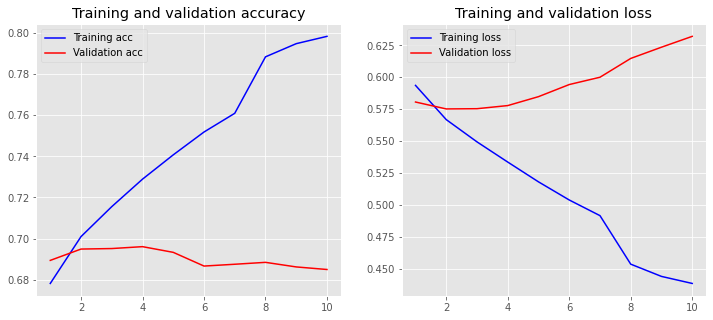

In [ ]:
plot_history(history)

## Observations:
1. A simple MLP model without pre-trained word embeddings gave us a validation accuracy of 0.69609.
2. Simple MLP model gave a validation accuracy which was 6% higher than baseline model.

## 6. Tokenization and Padding

In [ ]:
!unzip /content/drive/MyDrive/Case_Study_2/glove.42B.300d.zip

Archive:  /content/drive/MyDrive/Case_Study_2/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


### 6.1 Tokenization

In [5]:
# Tokenization
t = Tokenizer()
t.fit_on_texts(X_train['comment'])
tokens_train = t.texts_to_sequences(X_train['comment'])
tokens_test = t.texts_to_sequences(X_test['comment'])

In [6]:
print("Original Comment: ", X_train['comment'].iloc[0])
print("Tokenized Comment: ", tokens_train[0])

Original Comment:  welcome to jurassic park
Tokenized Comment:  [867, 4, 8964, 1288]


In [7]:
vocab_size = len(t.word_index) + 1
print("Total unique words: ", vocab_size)

Total unique words:  177731


In [8]:
# Saving pickle file of tokenizer object
with open('/content/drive/MyDrive/Case_Study_2/tokenizer.pkl', 'wb') as f:
    pickle.dump(t, f)

### 6.2 Padding sequences

Since 97% comments have less than 30 words. Let's pad each sequence to have 30 words.

In [9]:
padded_train = pad_sequences(tokens_train, maxlen=30, dtype='int32', 
                        padding='post', truncating='post', value=0.0)
padded_test = pad_sequences(tokens_test, maxlen=30, dtype='int32', 
                        padding='post', truncating='post', value=0.0)

In [10]:
padded_train.shape, padded_test.shape

((807784, 30), (201947, 30))

## 7. MLP with Glove Embeddings

### 7.1 Embedding

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix('/content/glove.42B.300d.txt', 
                                           t.word_index, embedding_dim)
embedding_matrix.shape

(177731, 100)

In [ ]:
# Saving 100-D embeddings
with open('/content/drive/MyDrive/Case_Study_2/glove_embedding100.npy', 'wb') as f:
    np.save(f, embedding_matrix)

In [ ]:
# Saving 300-D embeddings
with open('/content/drive/MyDrive/Case_Study_2/glove_embeddinga.npy', 'wb') as f:
    np.save(f, embedding_matrix)

In [ ]:
# Proportion of non-zero embedding vectors
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6523960367071586

65% words in vocabulary have been embedded with non-zero vectors using Glove pre-trained model.

### 7.2 Callbacks

In [ ]:
# Callback to save model
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/Case_Study_2/glove_model1'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

In [ ]:
# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)

In [ ]:
callback = [checkpoint, reduce_lr]

### 7.3 Model Training

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=30, trainable=False)(input_layer)
maxpool1 = layers.GlobalMaxPool1D()(embed_layer)
dense1 = layers.Dense(128, activation='relu')(maxpool1)
drop1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(64, activation='relu')(drop1)
drop2 = layers.Dropout(0.2)(dense2)
dense3 = layers.Dense(32, activation='relu')(drop2)
output_layer = layers.Dense(1, activation='sigmoid')(dense3)
glove_model = Model(input_layer, output_layer)
glove_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           53319300  
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
# compiling model
glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = glove_model.fit(padded_train, y_train, batch_size=64, epochs=15, 
                          validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/15
12620/12622 [============================>.] - ETA: 0s - loss: 0.6485 - accuracy: 0.6128
Epoch 00001: val_accuracy improved from -inf to 0.63719, saving model to /content/drive/MyDrive/Case_Study_2/glove_model1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/glove_model1/assets
12622/12622 [==============================] - 55s 4ms/step - loss: 0.6485 - accuracy: 0.6128 - val_loss: 0.6339 - val_accuracy: 0.6372 - lr: 0.0010
Epoch 2/15
12617/12622 [============================>.] - ETA: 0s - loss: 0.6347 - accuracy: 0.6304
Epoch 00002: val_accuracy improved from 0.63719 to 0.64306, saving model to /content/drive/MyDrive/Case_Study_2/glove_model1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/glove_model1/assets
12622/12622 [==============================] - 55s 4ms/step - loss: 0.6347 - accuracy: 0.6304 - val_loss: 0.6292 - val_accuracy: 0.6431 - lr: 0.0010
Epoch 3/15
12612/12622 [============================>.] - ETA: 0s - loss:

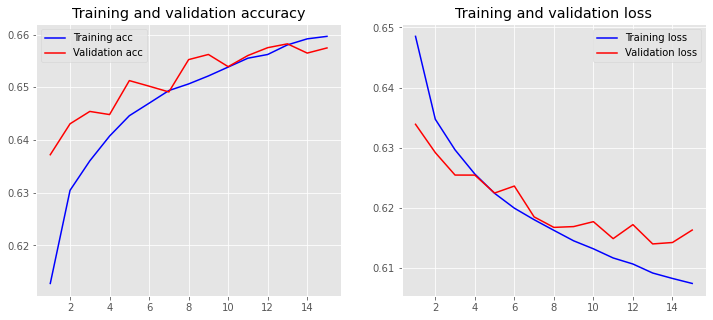

In [ ]:
plot_history(history)

## Observation:
1. Maximum validation accuracy of 0.65823 was achieved when pre-trained glove embeddings were used.
2. Model has started to overfit after 15 epochs of training.

## 8. Training Glove Embeddings

### 8.1 Callbacks

In [ ]:
# Callback to save model
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/Case_Study_2/glove_model3'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

In [ ]:
# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)

In [ ]:
callback = [checkpoint, reduce_lr]

### 8.2 Model Training

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=30, trainable=True)(input_layer)
maxpool1 = layers.GlobalMaxPool1D()(embed_layer)
dense1 = layers.Dense(128, activation='relu')(maxpool1)
drop1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(64, activation='relu')(drop1)
drop2 = layers.Dropout(0.2)(dense2)
dense3 = layers.Dense(32, activation='relu')(drop2)
output_layer = layers.Dense(1, activation='sigmoid')(dense3)
glove_model = Model(input_layer, output_layer)
glove_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           53319300  
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
# compiling model
glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = glove_model.fit(padded_train, y_train, batch_size=64, epochs=10, 
                          validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/10
12622/12622 [==============================] - ETA: 0s - loss: 0.5789 - accuracy: 0.6916
Epoch 00001: val_accuracy improved from -inf to 0.71458, saving model to /content/drive/MyDrive/Case_Study_2/glove_model2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/glove_model2/assets
12622/12622 [==============================] - 634s 50ms/step - loss: 0.5789 - accuracy: 0.6916 - val_loss: 0.5588 - val_accuracy: 0.7146 - lr: 0.0010
Epoch 2/10
12622/12622 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.7468
Epoch 00002: val_accuracy improved from 0.71458 to 0.71916, saving model to /content/drive/MyDrive/Case_Study_2/glove_model2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/glove_model2/assets
12622/12622 [==============================] - 633s 50ms/step - loss: 0.5132 - accuracy: 0.7468 - val_loss: 0.5511 - val_accuracy: 0.7192 - lr: 0.0010
Epoch 3/10
12622/12622 [==============================] - ETA: 0s - l

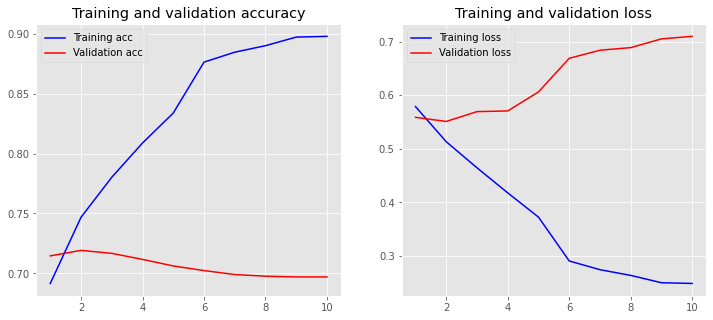

In [ ]:
plot_history(history)

## Observation
1. When pre-trained glove embeddings were trained, the model accuracy improved to 0.71916.
2. With increasing epochs, model started to overfit.

## 9. MLP with Fasttext Embeddings

### 9.1 Embedding

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 1.8 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3122740 sha256=fce51408b243d37dbc68f425d66c9e426ab453315072d6856da9c43d4fcf549a
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import fasttext
ft = fasttext.load_model('/content/drive/MyDrive/Case_Study_2/cc.en.300.bin')

In [ ]:
def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word in word_index:
        idx = word_index[word]
        embedding_matrix[idx] = ft.get_word_vector(word)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(t.word_index, embedding_dim)
embedding_matrix.shape

(177731, 300)

In [ ]:
# Saving 300-D embeddings fasttext embeddings
with open('/content/drive/MyDrive/Case_Study_2/fasttext_embeddings.npy', 'wb') as f:
    np.save(f, embedding_matrix)

In [ ]:
# loading embeddings
with open('/content/drive/MyDrive/Case_Study_2/fasttext_embeddings.npy', 'rb') as f:
    embedding_matrix = np.load(f)
embedding_dim = embedding_matrix.shape[1]
embedding_matrix.shape

(177731, 300)

In [ ]:
# Proportion of non-zero embedding vectors
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9999887470390647

### 9.2 Callbacks

In [ ]:
# Callback to save model
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/Case_Study_2/fasttext_model1'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

In [ ]:
# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)

In [ ]:
callback = [checkpoint, reduce_lr]

### 9.3 Model Training

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=30, trainable=False)(input_layer)
maxpool1 = layers.GlobalMaxPool1D()(embed_layer)
dense1 = layers.Dense(128, activation='relu')(maxpool1)
drop1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(64, activation='relu')(drop1)
drop2 = layers.Dropout(0.2)(dense2)
dense3 = layers.Dense(32, activation='relu')(drop2)
output_layer = layers.Dense(1, activation='sigmoid')(dense3)
fasttext_model = Model(input_layer, output_layer)
fasttext_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           53319300  
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
# compiling model
fasttext_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = fasttext_model.fit(padded_train, y_train, batch_size=64, epochs=15, 
                          validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/15
12611/12622 [============================>.] - ETA: 0s - loss: 0.6533 - accuracy: 0.6080
Epoch 00001: val_accuracy improved from -inf to 0.62647, saving model to /content/drive/MyDrive/Case_Study_2/fasttext_model1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/fasttext_model1/assets
12622/12622 [==============================] - 60s 5ms/step - loss: 0.6533 - accuracy: 0.6080 - val_loss: 0.6376 - val_accuracy: 0.6265 - lr: 0.0010
Epoch 2/15
12621/12622 [============================>.] - ETA: 0s - loss: 0.6406 - accuracy: 0.6230
Epoch 00002: val_accuracy improved from 0.62647 to 0.63109, saving model to /content/drive/MyDrive/Case_Study_2/fasttext_model1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/fasttext_model1/assets
12622/12622 [==============================] - 62s 5ms/step - loss: 0.6406 - accuracy: 0.6230 - val_loss: 0.6347 - val_accuracy: 0.6311 - lr: 0.0010
Epoch 3/15
12620/12622 [============================>.] - ETA

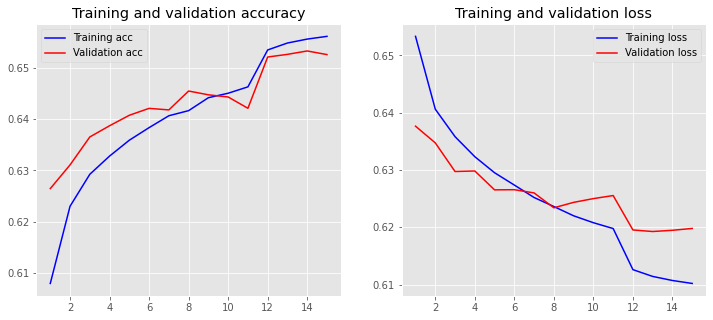

In [ ]:
plot_history(history)

## 10. Training fasttext embeddings

### 10.1 Callbacks

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Callback to save model
filepath = '/content/drive/MyDrive/Case_Study_2/fasttext_model2'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)

callback = [checkpoint, reduce_lr]

### 10.2 Model Training

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=30, trainable=True)(input_layer)
maxpool1 = layers.GlobalMaxPool1D()(embed_layer)
dense1 = layers.Dense(128, activation='relu')(maxpool1)
drop1 = layers.Dropout(0.2)(dense1)
dense2 = layers.Dense(64, activation='relu')(drop1)
drop2 = layers.Dropout(0.2)(dense2)
dense3 = layers.Dense(32, activation='relu')(drop2)
output_layer = layers.Dense(1, activation='sigmoid')(dense3)
fasttext_model = Model(input_layer, output_layer)
fasttext_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           53319300  
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
# compiling model
fasttext_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = fasttext_model.fit(padded_train, y_train, batch_size=64, epochs=15, 
                          validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/15
12621/12622 [============================>.] - ETA: 0s - loss: 0.5721 - accuracy: 0.6979
Epoch 00001: val_accuracy improved from -inf to 0.71331, saving model to /content/drive/MyDrive/Case_Study_2/fasttext_model2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/fasttext_model2/assets
12622/12622 [==============================] - 568s 45ms/step - loss: 0.5721 - accuracy: 0.6979 - val_loss: 0.5525 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 2/15
12621/12622 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.7539
Epoch 00002: val_accuracy improved from 0.71331 to 0.71723, saving model to /content/drive/MyDrive/Case_Study_2/fasttext_model2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/fasttext_model2/assets
12622/12622 [==============================] - 562s 45ms/step - loss: 0.5052 - accuracy: 0.7539 - val_loss: 0.5556 - val_accuracy: 0.7172 - lr: 0.0010
Epoch 3/15
12621/12622 [============================>.] -

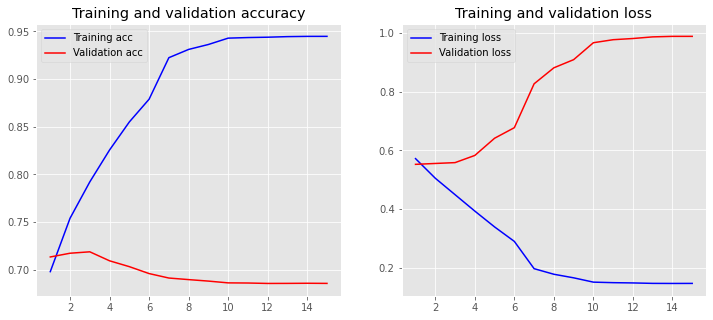

In [ ]:
plot_history(history)

## Observations
1. Fasttext Embeddings when trained gave a better validation accuracy of 0.7187.
2. Both glove embeddings and fasttext embeddings gave similar results, with glove embeddings giving a slightly better accuracy of 0.71916.
3. Both models trained on glove embeddings and fasttext embeddings started to  overfit with increasing epochs.
3. Fasttext embeddings covered 99% of words in train data where as glove embeddings covered 65% of words in train data.


## 11. CNN

In [ ]:
# loading glove embeddings
with open('/content/drive/MyDrive/Case_Study_2/glove_embeddinga.npy', 'rb') as f:
    embedding_matrix = np.load(f)
embedding_dim = embedding_matrix.shape[1]
embedding_matrix.shape

(177731, 300)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Callback to save model
filepath = '/content/drive/MyDrive/Case_Study_2/cnn_model1'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

# Reduce learning rate by 10% if val acc didn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)

callback = [checkpoint, reduce_lr]

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=30, trainable=False)(input_layer)
cnn1 = layers.Conv1D(128, 5, activation='relu')(embed_layer)
maxpool1 = layers.GlobalMaxPool1D()(cnn1)
dense1 = layers.Dense(10, activation='relu')(maxpool1)
output_layer = layers.Dense(1, activation='sigmoid')(dense1)
cnn_model = Model(input_layer, output_layer)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           53319300  
                                                                 
 conv1d (Conv1D)             (None, 26, 128)           192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                             

In [ ]:
# compiling model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = cnn_model.fit(padded_train, y_train, batch_size=64, epochs=10, 
                        validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/10
12621/12622 [============================>.] - ETA: 0s - loss: 0.5783 - accuracy: 0.6893
Epoch 00001: val_accuracy improved from -inf to 0.70837, saving model to /content/drive/MyDrive/Case_Study_2/cnn_model1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/cnn_model1/assets
12622/12622 [==============================] - 429s 34ms/step - loss: 0.5783 - accuracy: 0.6893 - val_loss: 0.5571 - val_accuracy: 0.7084 - lr: 0.0010
Epoch 2/10
12621/12622 [============================>.] - ETA: 0s - loss: 0.5423 - accuracy: 0.7206
Epoch 00002: val_accuracy improved from 0.70837 to 0.71056, saving model to /content/drive/MyDrive/Case_Study_2/cnn_model1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Case_Study_2/cnn_model1/assets
12622/12622 [==============================] - 392s 31ms/step - loss: 0.5423 - accuracy: 0.7206 - val_loss: 0.5563 - val_accuracy: 0.7106 - lr: 0.0010
Epoch 3/10
12621/12622 [============================>.] - ETA: 0s - loss: 0.5

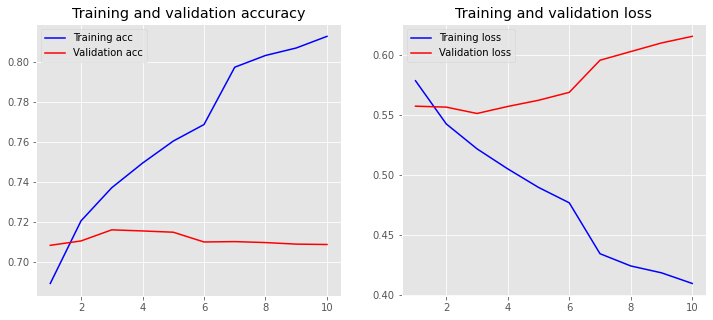

In [ ]:
plot_history(history)

## Observations
1. CNN 1D model achieved a maximum validation accuracy of 0.71610.
2. Simple MLP with trained glove embeddings gave better validation accuracy of 0.71916.

## 12. LSTM

### 12.1 LSTM with 2 dense layers

In [ ]:
# Callback to save model
from tensorflow.keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/Case_Study_2/lstm_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)

callback = [checkpoint]

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=30, trainable=False)(input_layer)
lstm1 = layers.LSTM(128)(embed_layer)
drop1 = layers.Dropout(0.20)(lstm1)
dense1 = layers.Dense(128, activation='relu')(drop1)
drop2 = layers.Dropout(0.20)(dense1)
dense2 = layers.Dense(64, activation='relu')(drop2)
output_layer = layers.Dense(1, activation='sigmoid')(dense2)
lstm_model = Model(input_layer, output_layer)
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           53319300  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [ ]:
# compiling model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = lstm_model.fit(padded_train, y_train, batch_size=64, epochs=10, 
                        validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/10
12619/12622 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.6992
Epoch 00001: val_accuracy improved from -inf to 0.71933, saving model to /content/drive/MyDrive/Case_Study_2/lstm_model.hdf5
12622/12622 [==============================] - 185s 14ms/step - loss: 0.5700 - accuracy: 0.6992 - val_loss: 0.5449 - val_accuracy: 0.7193
Epoch 2/10
12621/12622 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.7335
Epoch 00002: val_accuracy improved from 0.71933 to 0.73415, saving model to /content/drive/MyDrive/Case_Study_2/lstm_model.hdf5
12622/12622 [==============================] - 178s 14ms/step - loss: 0.5287 - accuracy: 0.7335 - val_loss: 0.5275 - val_accuracy: 0.7342
Epoch 3/10
12621/12622 [============================>.] - ETA: 0s - loss: 0.5088 - accuracy: 0.7479
Epoch 00003: val_accuracy improved from 0.73415 to 0.73479, saving model to /content/drive/MyDrive/Case_Study_2/lstm_model.hdf5
12622/12622 [==============================

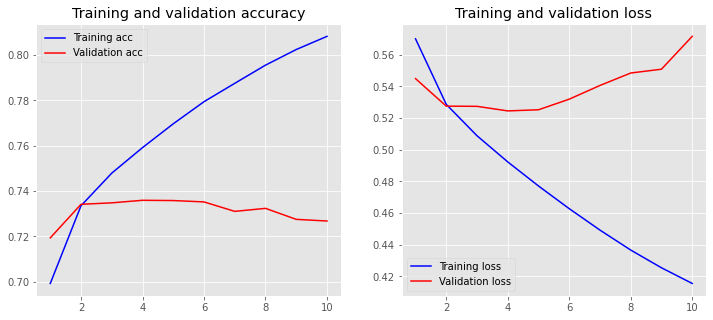

In [ ]:
plot_history(history)

### Observations
1. LSTM model achieved a maximum validation accuracy of 0.73592.
2. Out of all DL models trained previously, LSTM model gave the best validation accuracy.

### 12.2 LSTM with no dense hidden layers

In [ ]:
filepath = '/content/drive/MyDrive/Case_Study_2/lstm_model2.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
callback = [checkpoint]

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=30, trainable=False)(input_layer)
lstm1 = layers.LSTM(128)(embed_layer)
drop1 = layers.Dropout(0.20)(lstm1)
output_layer = layers.Dense(1, activation='sigmoid')(drop1)
lstm_model = Model(input_layer, output_layer)
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           53319300  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 53,539,077
Trainable params: 219,777
Non-trainable params: 53,319,300
_________________________________________________________________


In [ ]:
# compiling model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = lstm_model.fit(padded_train, y_train, batch_size=64, epochs=5, 
                        validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/5
12620/12622 [============================>.] - ETA: 0s - loss: 0.5681 - accuracy: 0.7009
Epoch 00001: val_accuracy improved from -inf to 0.71790, saving model to /content/drive/MyDrive/Case_Study_2/lstm_model2.hdf5
12622/12622 [==============================] - 212s 16ms/step - loss: 0.5681 - accuracy: 0.7009 - val_loss: 0.5448 - val_accuracy: 0.7179
Epoch 2/5
12621/12622 [============================>.] - ETA: 0s - loss: 0.5275 - accuracy: 0.7336
Epoch 00002: val_accuracy improved from 0.71790 to 0.73388, saving model to /content/drive/MyDrive/Case_Study_2/lstm_model2.hdf5
12622/12622 [==============================] - 178s 14ms/step - loss: 0.5275 - accuracy: 0.7336 - val_loss: 0.5271 - val_accuracy: 0.7339
Epoch 3/5
12619/12622 [============================>.] - ETA: 0s - loss: 0.5071 - accuracy: 0.7483
Epoch 00003: val_accuracy did not improve from 0.73388
12622/12622 [==============================] - 171s 14ms/step - loss: 0.5071 - accuracy: 0.7483 - val_loss: 0.5317 - 

In [ ]:
# training model
history = lstm_model.fit(padded_train, y_train, batch_size=64, epochs=5, 
                        validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/5
12620/12622 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.7806
Epoch 00001: val_accuracy did not improve from 0.73637
12622/12622 [==============================] - 168s 13ms/step - loss: 0.4601 - accuracy: 0.7806 - val_loss: 0.5343 - val_accuracy: 0.7337
Epoch 2/5
12622/12622 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.7896
Epoch 00002: val_accuracy did not improve from 0.73637
12622/12622 [==============================] - 174s 14ms/step - loss: 0.4462 - accuracy: 0.7896 - val_loss: 0.5476 - val_accuracy: 0.7302
Epoch 3/5
12619/12622 [============================>.] - ETA: 0s - loss: 0.4339 - accuracy: 0.7974
Epoch 00003: val_accuracy did not improve from 0.73637
12622/12622 [==============================] - 178s 14ms/step - loss: 0.4339 - accuracy: 0.7974 - val_loss: 0.5502 - val_accuracy: 0.7295
Epoch 4/5
12619/12622 [============================>.] - ETA: 0s - loss: 0.4220 - accuracy: 0.8047
Epoch 00004: val_accuracy

### Observations
1. Simple LSTM model with no dense layers, gave slightly better results compared to LSTM model with dense layers.
2. Maximum validation accuracy of 0.73637 was achieved with above LSTM model.

## 13. Bidirectional LSTM

In [ ]:
filepath = '/content/drive/MyDrive/Case_Study_2/bi_lstm_model1.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
callback = [checkpoint]

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()
input_layer = layers.Input(shape=(30,))
embed_layer = layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                              input_length=30, trainable=False)(input_layer)
lstm1 = layers.Bidirectional(layers.LSTM(128))(embed_layer)
drop1 = layers.Dropout(0.20)(lstm1)
output_layer = layers.Dense(1, activation='sigmoid')(drop1)
bilstm_model = Model(input_layer, output_layer)
bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           53319300  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 53,758,853
Trainable params: 439,553
Non-trainable params: 53,319,300
___________________________________________

In [ ]:
# compiling model
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training model
history = bilstm_model.fit(padded_train, y_train, batch_size=64, epochs=10, 
                        validation_data=(padded_test, y_test), callbacks=callback)

Epoch 1/10
12621/12622 [============================>.] - ETA: 0s - loss: 0.5618 - accuracy: 0.7052
Epoch 00001: val_accuracy improved from -inf to 0.72734, saving model to /content/drive/MyDrive/Case_Study_2/bi_lstm_model1.hdf5
12622/12622 [==============================] - 311s 24ms/step - loss: 0.5618 - accuracy: 0.7052 - val_loss: 0.5349 - val_accuracy: 0.7273
Epoch 2/10
12622/12622 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.7356
Epoch 00002: val_accuracy improved from 0.72734 to 0.73492, saving model to /content/drive/MyDrive/Case_Study_2/bi_lstm_model1.hdf5
12622/12622 [==============================] - 309s 24ms/step - loss: 0.5241 - accuracy: 0.7356 - val_loss: 0.5260 - val_accuracy: 0.7349
Epoch 3/10
12621/12622 [============================>.] - ETA: 0s - loss: 0.5046 - accuracy: 0.7502
Epoch 00003: val_accuracy improved from 0.73492 to 0.73679, saving model to /content/drive/MyDrive/Case_Study_2/bi_lstm_model1.hdf5
12622/12622 [==================

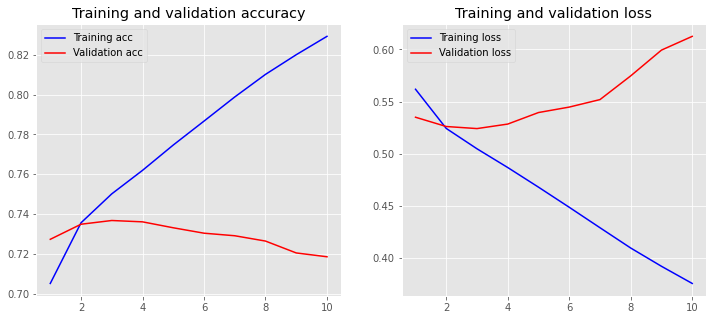

In [ ]:
plot_history(history)

## Observations:
1. Bidirectional LSTM model gave a maximum validation accuracy of 0.7368.
2. The best results were achieved with Bidirectional LSTM.

## 14. Best Model Evaluation

In [38]:
model = load_model('/content/drive/MyDrive/Case_Study_2/bi_lstm_model1.hdf5')

In [12]:
# prediction on train dataset
y_pred_train = model.predict(padded_train)

# prediction on test dataset
y_pred_test = model.predict(padded_test)

In [14]:
y_pred_train = np.where(y_pred_train>=0.5, 1, 0)
y_pred_test = np.where(y_pred_test>=0.5, 1, 0)

In [18]:
# Train Data Evaluation
print("Train Data Evaluation")
print()
print(classification_report(y_train, y_pred_train))

# Train Data Evaluation
print()
print("Test Data Evaluation")
print()
print(classification_report(y_test, y_pred_test))

Train Data Evaluation

              precision    recall  f1-score   support

           0       0.76      0.80      0.78    403621
           1       0.79      0.74      0.76    404163

    accuracy                           0.77    807784
   macro avg       0.77      0.77      0.77    807784
weighted avg       0.77      0.77      0.77    807784


Test Data Evaluation

              precision    recall  f1-score   support

           0       0.72      0.76      0.74    100906
           1       0.75      0.71      0.73    101041

    accuracy                           0.74    201947
   macro avg       0.74      0.74      0.74    201947
weighted avg       0.74      0.74      0.74    201947



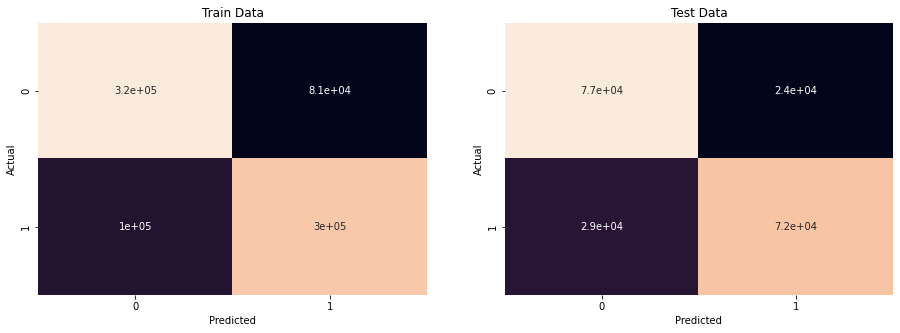

In [20]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
mat1 = confusion_matrix(y_train, y_pred_train)
df_tr = pd.DataFrame(mat1, columns=np.unique(y_train), index=np.unique(y_train))
df_tr.index.name = 'Actual'
df_tr.columns.name = 'Predicted'
mat2 = confusion_matrix(y_test, y_pred_test)
df_te = pd.DataFrame(mat2, columns=np.unique(y_train), index=np.unique(y_train))
df_te.index.name = 'Actual'
df_te.columns.name = 'Predicted'

plt.figure(figsize = (5, 5))
plt.subplot(1, 2, 1)
sns.heatmap(df_tr, annot=True, cbar=False)
plt.title("Train Data")
plt.subplot(1, 2, 2)
sns.heatmap(df_te, annot=True, cbar=False)
plt.title("Test Data")
plt.subplots_adjust(right=2.5)
plt.show()

## 15. Results and Conclusions

In [ ]:
myTable = PrettyTable(["Model", "Embedding", "Validation Accuracy"])
myTable.add_row(["Baseline Logistic Regression", "Fasttext", 0.6400])
myTable.add_row(["MLP", "One Hot Encoding", 0.6961])
myTable.add_row(["MLP", "Glove", 0.6582])
myTable.add_row(["MLP", "Glove(Trained)", 0.7192])
myTable.add_row(["MLP", "Fasttext", 0.6533])
myTable.add_row(["MLP", "Fasttext(Trained)", 0.7187])
myTable.add_row(["CNN", "Glove", 0.7161]) 
myTable.add_row(["LSTM", "Glove", 0.7364])
myTable.add_row(["Bidirectional LSTM", "Glove", 0.7368])
print(myTable)

+------------------------------+-------------------+---------------------+
|            Model             |     Embedding     | Validation Accuracy |
+------------------------------+-------------------+---------------------+
| Baseline Logistic Regression |      Fasttext     |         0.64        |
|             MLP              |  One Hot Encoding |        0.6961       |
|             MLP              |       Glove       |        0.6582       |
|             MLP              |   Glove(Trained)  |        0.7192       |
|             MLP              |      Fasttext     |        0.6533       |
|             MLP              | Fasttext(Trained) |        0.7187       |
|             CNN              |       Glove       |        0.7161       |
|             LSTM             |       Glove       |        0.7364       |
|      Bidirectional LSTM      |       Glove       |        0.7368       |
+------------------------------+-------------------+---------------------+


1. The best validation accuracy was obtained with Bidirectional LSTM model with Glove embeddings.
2. That best validation accuracy of 0.7368 was nearly 10% higher than baseline model.
3. All DL models started to overfit on data on training for more epochs.